In [1]:
import numpy  as np
import pandas as pd
# import seaborn as sns
import pandas_profiling
import seaborn as sns
import pickle

# Чтение данных

In [2]:
# информация о клиентах
df_clients = pd.read_csv('data/clients.csv', index_col='client_id', parse_dates=['first_issue_date', 'first_redeem_date'])
print(df_clients.shape)
df_clients.head()

(400162, 4)


first_issue_date   first_redeem_date  age gender
client_id                                                     
000012768d 2017-08-05 15:40:48 2018-01-04 19:30:07   45      U
000036f903 2017-04-10 13:54:23 2017-04-23 12:37:56   72      F
000048b7a6 2018-12-15 13:33:11                 NaT   68      F
000073194a 2017-05-23 12:56:14 2017-11-24 11:18:01   60      F
00007c7133 2017-05-22 16:17:08 2018-12-31 17:17:33   67      U

In [4]:
diff = df_clients['first_redeem_date'] - df_clients['first_issue_date']

In [7]:
(diff == 0).sum()

0

In [58]:
df_clients['first_issue_date'].min()

Timestamp('2017-04-04 18:24:18')

In [54]:
df_clients['first_redeem_date'].dt.second#   astype(int)#dt.total_seconds()

client_id
000012768d     7.0
000036f903    56.0
000048b7a6     NaN
000073194a     1.0
00007c7133    33.0
              ... 
fffece623e    39.0
ffff3dfff8    47.0
ffffaab9da    19.0
ffffeb5619     NaN
fffff6ce77    41.0
Name: first_redeem_date, Length: 400162, dtype: float64

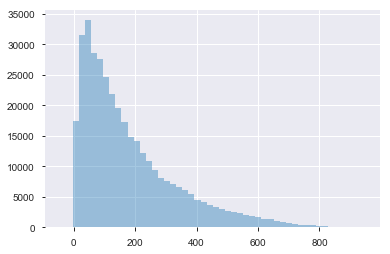

In [14]:
sns.distplot(diff[diff.notnull()].dt.days, kde=False)

In [15]:
# обучающая выборка клиентов, информация о коммуникации и конверсии
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
print(df_train.shape)
df_train.head()

(200039, 2)


treatment_flg  target
client_id                        
000012768d              0       1
000036f903              1       1
00010925a5              1       1
0001f552b0              1       1
00020e7b18              1       1

In [16]:
df_train['treatment_flg'].value_counts()

0    100058
1     99981
Name: treatment_flg, dtype: int64

In [17]:
df_train['target'].value_counts()

1    124002
0     76037
Name: target, dtype: int64

In [4]:
# тестовые клиенты, для которых необходимо оценить uplift
df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')
df_test.shape

(200123, 0)

In [3]:
# информация о товарах
df_products = pd.read_csv('data/products.csv')
print(df_products.shape)
df_products.head()

(43038, 11)


product_id     level_1     level_2     level_3     level_4  segment_id  \
0  0003020d3c  c3d3a8e8c6  c2a3ea8d5e  b7cda0ec0c  6376f2a852       123.0   
1  0003870676  e344ab2e71  52f13dac0c  d3cfe81323  6dc544533f       105.0   
2  0003ceaf69  c3d3a8e8c6  f2333c90fb  419bc5b424  f6148afbc0       271.0   
3  000701e093  ec62ce61e3  4202626fcb  88a515c084  48cf3d488f       172.0   
4  0007149564  e344ab2e71  52f13dac0c  d3cfe81323  6dc544533f       105.0   

     brand_id   vendor_id  netto  is_own_trademark  is_alcohol  
0  394a54a7c1  9eaff48661  0.400                 0           0  
1  acd3dd483f  10486c3cf0  0.680                 0           0  
2  f597581079  764e660dda  0.500                 0           0  
3  54a90fe769  03c2d70bad  0.112                 0           0  
4  63417fe1f3  f329130198  0.600                 0           0

In [4]:
for col in df_products.columns:
    nunique = df_products[col].nunique()
    print(col, nunique)

product_id 43038
level_1 3
level_2 42
level_3 201
level_4 790
segment_id 116
brand_id 4296
vendor_id 3193
netto 780
is_own_trademark 2
is_alcohol 2


In [5]:
df_clients = pd.read_csv('data/clients.csv', parse_dates=['first_issue_date', 'first_redeem_date'])
print(df_clients.shape)
df_clients.head()

(400162, 5)


client_id    first_issue_date   first_redeem_date  age gender
0  000012768d 2017-08-05 15:40:48 2018-01-04 19:30:07   45      U
1  000036f903 2017-04-10 13:54:23 2017-04-23 12:37:56   72      F
2  000048b7a6 2018-12-15 13:33:11                 NaT   68      F
3  000073194a 2017-05-23 12:56:14 2017-11-24 11:18:01   60      F
4  00007c7133 2017-05-22 16:17:08 2018-12-31 17:17:33   67      U

In [60]:
df_products['segment_id'].nunique()

116

In [61]:
df_products['segment_id'].isnull().sum()

1572

In [62]:
df_products.groupby('segment_id')['level_1'].count()

KeyError: 'Column not found: level_id'

In [18]:
# история покупок клиентов до смс кампании
df_purchases = pd.read_csv('data/purchases.csv', index_col='client_id', nrows=200000)
df_purchases.shape
df_purchases.head()

transaction_id transaction_datetime  regular_points_received  \
client_id                                                                 
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   

            express_points_received  regular_points_spent  \
client_id                                                   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   

            express_points_spent  purchase_sum    store_id  product_id  \
client_id                                                                
000012768d                   0.0        1007.0  54a4a11a29  9a80204f78   
000012768d                   0.0        1007.0  54a4a11a29  da89ebd374   
000012768d                   0.0        1007.0  54a4a11a29  0a95e1151d   
000012768d                   0.0        1007.0  54a4a11a29  4055b15e4a   
000012768d                   0.0        1007.0  54a4a11a29  a685f1916b   

            product_quantity  trn_sum_from_iss  trn_sum_from_red  
client_id                                                         
000012768d               2.0              80.0               NaN  
000012768d               1.0              65.0               NaN  
000012768d               1.0              24.0               NaN  
000012768d               2.0              50.0               NaN  
000012768d               1.0              22.0               NaN

In [19]:
df_purchases.head(20)

transaction_id transaction_datetime  regular_points_received  \
client_id                                                                 
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
000012768d     c1ca85d462  2018-12-16 08:56:01                      5.7   

            express_points_received  regular_points_spent  \
client_id                                                   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   

            express_points_spent  purchase_sum    store_id  product_id  \
client_id                                                                
000012768d                   0.0        1007.0  54a4a11a29  9a80204f78   
000012768d                   0.0        1007.0  54a4a11a29  da89ebd374   
000012768d                   0.0        1007.0  54a4a11a29  0a95e1151d   
000012768d                   0.0        1007.0  54a4a11a29  4055b15e4a   
000012768d                   0.0        1007.0  54a4a11a29  a685f1916b   
000012768d                   0.0        1007.0  54a4a11a29  21db5dbe53   
000012768d                   0.0        1007.0  54a4a11a29  1e208d0b4c   
000012768d                   0.0        1007.0  54a4a11a29  15ccaa8685   
000012768d                   0.0        1007.0  54a4a11a29  45389bb5b0   
000012768d                   0.0        1007.0  54a4a11a29  cb4c804130   
000012768d                   0.0        1007.0  54a4a11a29  7c39f1d12c   
000012768d                   0.0        1007.0  54a4a11

In [66]:
df_purchases['transaction_datetime'].max()

'2019-03-18 19:49:10'

In [73]:
df_purchases.query('product_id == "3ca2d19cd3"').head(20)

transaction_id transaction_datetime  regular_points_received  \
client_id                                                                 
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
00055427d8     121b1d925b  2018-11-28 15:19:34                      0.0   
0006c801df     1a9f3b47d0  2019-01-14 06:58:54                      7.7   
000d007ae1     d3be17a8a6  2019-03-14 10:58:13                      0.0   
00121553fa     730066837f  2018-11-22 12:30:24                      1.7   
00174b3561     fc2fdbe12f  2019-01-22 16:08:17                     11.0   
00174b3561     53ee7f1d25  2019-02-13 18:05:28                      1.8   
001b3619df     7eda58ea30  2018-11-24 08:42:01                      8.0   
002b4e86ab     f58aa9cef4  2018-12-30 19:26:38                     29.1   
0031320636     795878f4fe  2019-02-26 06:55:01                      1.9   
0031320636     2bd6b9966c  2019-03-10 06:52:11                      1.0   
00318398bc     4f91d8ecf4  2019-03-13 16:07:17                     12.8   
0031a646ab     a4bfb0787b  2019-02-21 10:33:15                     21.0   
00335b315c     ecb77d2fa0  2019-03-13 11:57:31                      2.3   
0038db8951     1ae9ebe1cc  2019-01-28 21:58:11                     12.8   
003b9c13e7     7c2fcf2882  2018-12-29 09:55:19                      2.5   
003f325b7d     4fe44110ed  2018-12-25 06:28:07                      0.6   
0050223b8f     fed7e4776f  2019-03-05 13:29:30                     14.7   
005a95883f     e9db86f075  2018-12-09 09:15:55                      1.9   
006c24b63a     5132816849  2018-12-28 12:29:53                      0.8   

            express_points_received  regular_points_spent  \
client_id                                                   
000012768d                      0.0                   0.0   
00055427d8                      0.0                   0.0   
0006c801df                      0.0                   0.0   
000d007ae1                      0.0                 -41.0   
00121553fa                      0.0                   0.0   
00174b3561                      0.0                   0.0   
00174b3561                      0.0                   0.0   
001b3619df                      0.0                   0.0   
002b4e86ab                      0.0                   0.0   
0031320636                      0.0                   0.0   
0031320636                      0.0                   0.0   
00318398bc                      0.0                   0.0   
0031a646ab                      0.0                   0.0   
00335b315c                      0.0                   0.0   
0038db8951                      0.0                   0.0   
003b9c13e7                      0.0                   0.0   
003f325b7d                      0.0                   0.0   
0050223b8f                      0.0                   0.0   
005a95883f                      0.0                   0.0   
006c24b63a                      0.0                   0.0   

            express_points_spent  purchase_sum    store_id  product_id  \
client_id                                                                
000012768d                   0.0        803.00  017c89b915  3ca2d19cd3   
00055427d8                   0.0         17.00  c1dea4d2a6  3ca2d19cd3   
0006c801df                   0.0        777.00  7c9cfe228a  3ca2d19cd3   
000d007ae1                   0.0         41.00  6bfe21ed7b  3ca2d19cd3   
00121553fa                   0.0        349.17  c007c1ce23  3ca2d19cd3   
00174b3561                   0.0       1105.05  68adb6c3b0  3ca2d19cd3   
00174b3561                   0.0        376.00  68adb6c3b0  3ca2d19cd3   
001b3619df                   0.0        802.00  268e8f7d61  3ca2d19cd3   
002b4e86ab                   0.0       2916.00  cd8037ce56  3ca2d19cd3   
0031320636                   0.0        381.00  25a0498498  3ca2d19cd3   
0031320636                   0.0        214.00  25a0498498  3ca2d19cd3   
00318398bc                   0.0       1285.00  73dc7aa

In [71]:
df_purchases[df_purchases['transaction_id'] == '6a0e96d0bc']#['trn_sum_from_iss'].sum()

transaction_id transaction_datetime  regular_points_received  \
client_id                                                                 
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   

            express_points_received  regular_points_spent  \
client_id                                                   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   

            express_points_spent  purchase_sum    store_id  product_id  \
client_id                                                                
000012768d                   0.0         803.0  017c89b915  36294f82c2   
000012768d                   0.0         803.0  017c89b915  785b8ca3d3   
000012768d                   0.0         803.0  017c89b915  3ca2d19cd3   
000012768d                   0.0         803.0  017c89b915  c55ed13ebd   
000012768d                   0.0         803.0  017c89b915  d41bdf4285   
000012768d                   0.0         803.0  017c89b915  25be5dc299   
000012768d                   0.0         803.0  017c89b915  32ac3fc229   
000012768d                   0.0         803.0  017c89b915  5645789fdf   
000012768d                   0.0         803.0  017c89b915  c4ec937ca8   
000012768d                   0.0         803.0  017c89b915  628485eabc   
000012768d                   0.0         803.0  017c89b915  30d718e106   
000012768d                   0.0         803.0  017c89b915  4b9111aee1   
000012768d                   0.0         803.0  017c89b915  24fc3df201   
000012768d                   0.0         803.0  017c89b915  fa8ba5149d   
000012768d                   0.0         803.0  017c89b915  2080d1ce9d   
000012768d                   0.0         803.0  017c89b915  60d701d7db   

            product_quantity  trn_sum_from_iss  trn_sum_from_red  
client_id                                                         
000012768d               1.0              50.0               NaN  
000012768d               1.

In [68]:
df_purchases[df_purchases['product_quantity'] == 0]

transaction_id transaction_datetime  regular_points_received  \
client_id                                                                 
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     6a0e96d0bc  2019-03-08 10:12:03                      8.0   
000012768d     b34f23306e  2019-03-14 15:01:47                      2.0   
000036f903     12b218b054  2018-11-28 10:48:36                      1.2   
...                   ...                  ...                      ...   
011ff9e5a5     df4b72853e  2018-12-08 17:06:55                      2.1   
011ff9e5a5     df4b72853e  2018-12-08 17:06:55                      2.1   
011ff9e5a5     92d07ed6e1  2018-12-16 17:00:16                      5.7   
011ff9e5a5     92d07ed6e1  2018-12-16 17:00:16                      5.7   
011ff9e5a5     b112b60884  2019-01-18 10:39:06                      0.9   

            express_points_received  regular_points_spent  \
client_id                                                   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000012768d                      0.0                   0.0   
000036f903                      0.0                   0.0   
...                             ...                   ...   
011ff9e5a5                      0.0                   0.0   
011ff9e5a5                      0.0                   0.0   
011ff9e5a5                      0.0                   0.0   
011ff9e5a5                      0.0                   0.0   
011ff9e5a5                      0.0                   0.0   

            express_points_spent  purchase_sum    store_id  product_id  \
client_id                                                                
000012768d                   0.0         803.0  017c89b915  3ca2d19cd3   
000012768d                   0.0         803.0  017c89b915  4b9111aee1   
000012768d                   0.0         803.0  017c89b915  fa8ba5149d   
000012768d                   0.0         419.0  017c89b915  fa8ba5149d   
000036f903                   0.0         241.0  6381a55c22  f6ad31e071   
...                          ...           ...         ...         ...   
011ff9e5a5                   0.0         422.0  8612c279f0  4a29330c8d   
011ff9e5a5                   0.0         422.0  8612c279f0  70d4730470   
011ff9e5a5                   0.0         575.0  8612c279f0  e1cf29d336   
011ff9e5a5                   0.0         575.0  8612c279f0  4a29330c8d   
011ff9e5a5                   0.0         185.0  8612c279f0  d860464ae1   

            product_quantity  trn_sum_from_iss  trn_sum_from_red  
client_id                                                         
000012768d               0.0              21.0               NaN  
000012768d               0.0              26.0               NaN  
000012768d               0.0              58.0               NaN  
000012768d               0.0              74.0               NaN  
000036f903               0.0              32.0               NaN  
...                      ...               ...               ...  
011ff9e5a5               0.0              13.0               NaN  
011ff9e5a5               0.0              71.0               NaN  
011ff9e5a5               0.0             108.0               NaN  
011ff9e5a5               0.0              30.0               NaN  
011ff9e5a5               0.0              43.0               NaN  

[11816 rows x 12 columns]

In [33]:
sum_red_notnull = df_purchases[
    df_purchases['trn_sum_from_red'].notnull()
#     (df_purchases['trn_sum_from_red'] == df_purchases['trn_sum_from_iss'])
]#.head(20)

In [39]:
df_purchases.isnull().sum()

transaction_id                  0
transaction_datetime            0
regular_points_received         0
express_points_received         0
regular_points_spent            0
express_points_spent            0
purchase_sum                    0
store_id                        0
product_id                      0
product_quantity                0
trn_sum_from_iss                0
trn_sum_from_red           185961
dtype: int64

In [34]:
sum_red_notnull.shape

(14039, 12)

In [46]:
df_purchases[
    (df_purchases['trn_sum_from_red'].notnull()) &
    (df_purchases['regular_points_spent'] == 0) & 
    (df_purchases['express_points_spent'] == 0) &
    (df_purchases['trn_sum_from_red']  df_purchases['trn_sum_from_iss'])
]

Empty DataFrame
Columns: [transaction_id, transaction_datetime, regular_points_received, express_points_received, regular_points_spent, express_points_spent, purchase_sum, store_id, product_id, product_quantity, trn_sum_from_iss, trn_sum_from_red]
Index: []

In [31]:
df_purchases[df_purchases['transaction_id'] == '6bbd8c949e']

transaction_id transaction_datetime  regular_points_received  \
client_id                                                                 
000073194a     6bbd8c949e  2019-01-12 09:40:34                      0.1   
000073194a     6bbd8c949e  2019-01-12 09:40:34                      0.1   
000073194a     6bbd8c949e  2019-01-12 09:40:34                      0.1   
000073194a     6bbd8c949e  2019-01-12 09:40:34                      0.1   
000073194a     6bbd8c949e  2019-01-12 09:40:34                      0.1   
000073194a     6bbd8c949e  2019-01-12 09:40:34                      0.1   

            express_points_received  regular_points_spent  \
client_id                                                   
000073194a                      0.0                 -96.0   
000073194a                      0.0                 -96.0   
000073194a                      0.0                 -96.0   
000073194a                      0.0                 -96.0   
000073194a                      0.0                 -96.0   
000073194a                      0.0                 -96.0   

            express_points_spent  purchase_sum    store_id  product_id  \
client_id                                                                
000073194a                   0.0        130.84  9e8fcd116d  5d34b577c1   
000073194a                   0.0        130.84  9e8fcd116d  60170ba1cb   
000073194a                   0.0        130.84  9e8fcd116d  2ebda832fa   
000073194a                   0.0        130.84  9e8fcd116d  990abf83f9   
000073194a                   0.0        130.84  9e8fcd116d  3f91bbfc2a   
000073194a                   0.0        130.84  9e8fcd116d  0990d68c91   

            product_quantity  trn_sum_from_iss  trn_sum_from_red  
client_id                                                         
000073194a               1.0               5.0              20.0  
000073194a               5.0               9.0              35.0  
000073194a               3.0               7.0              27.0  
000073194a               2.0               4.0              14.0  
000073194a               2.0               4.0              14.0  
000073194a               3.0               6.0              21.0

# Анализ данных

## df_clients

In [23]:
pandas_profiling.ProfileReport(df_clients)

KeyboardInterrupt: 

## df_train

In [14]:
pandas_profiling.ProfileReport(df_train)

## df_products

In [15]:
pandas_profiling.ProfileReport(df_products)

## df_purchases

In [16]:
pandas_profiling.ProfileReport(df_purchases)

In [ ]:
sns.distplot(, kde=kde, hist=hist, label='Label=1', norm_hist=True)